In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pylab as pylab
import numpy as np
from copy import copy
import os
from PIL import Image
import cv2
from skimage import io
from skimage import color
from skimage.feature import canny
import time

In [3]:
def preProcess(img_path, shape):
    # Read and Copy Image for Writing
    img = readResize(img_path, shape)
    
    # Flip to face breast towards right
    newIm = flipImage(img)
    
    # Background Removal
    newIm = backgroundRemoval(newIm)
    
    # Bar Removal
    newIm = barRemover(newIm, 200)
    finIm = copy(newIm)

    # Pectoral Muscle Removal
    if  "CC" not in img_path:
        canNum = 6
        loop = True
        while loop == True:
            if canNum <= 0:
                finIm = copy(newIm)
                loop = False
            else:
                with np.warnings.catch_warnings():
                    np.warnings.filterwarnings('error')
                    try:
                        finIm = cropPecCanny(newIm, 7, canNum)
                        break
                    except np.RankWarning:
                        canNum -= 1
                    except TypeError:
                        canNum -= 1
                    except cutError:
                        canNum -= 1
        
    return finIm
        

<Figure size 1440x1280 with 0 Axes>

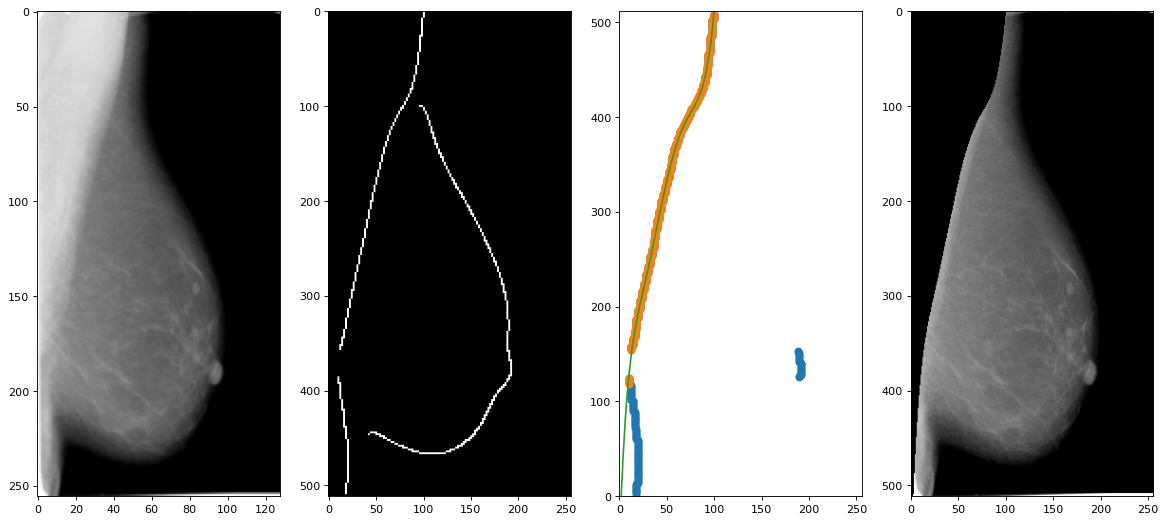

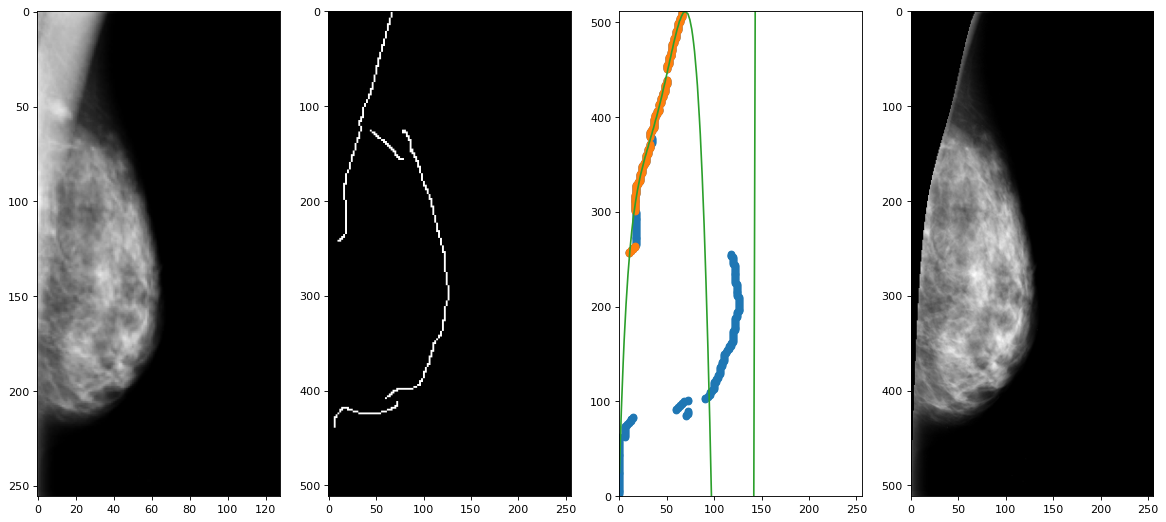

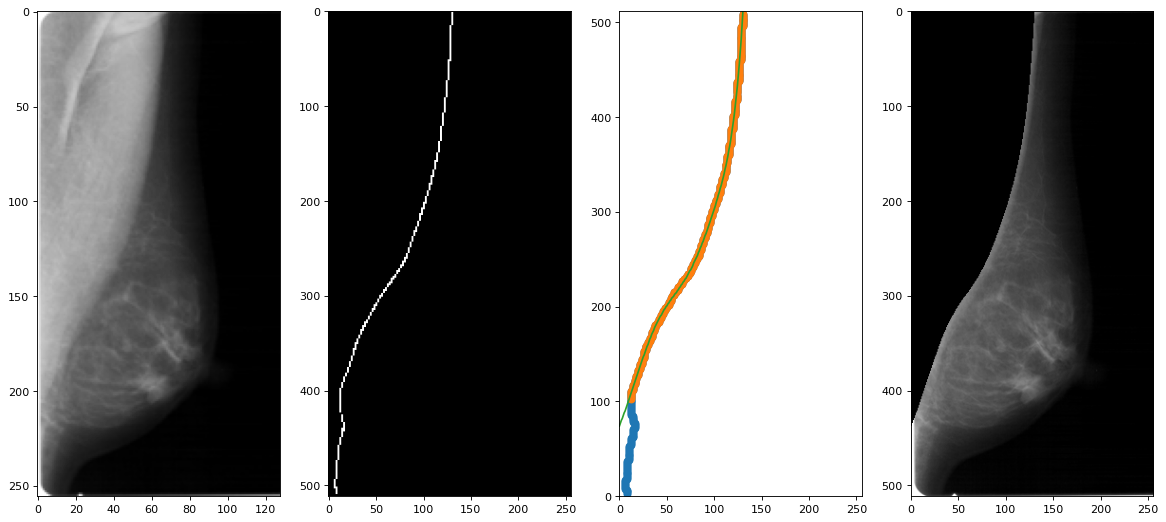

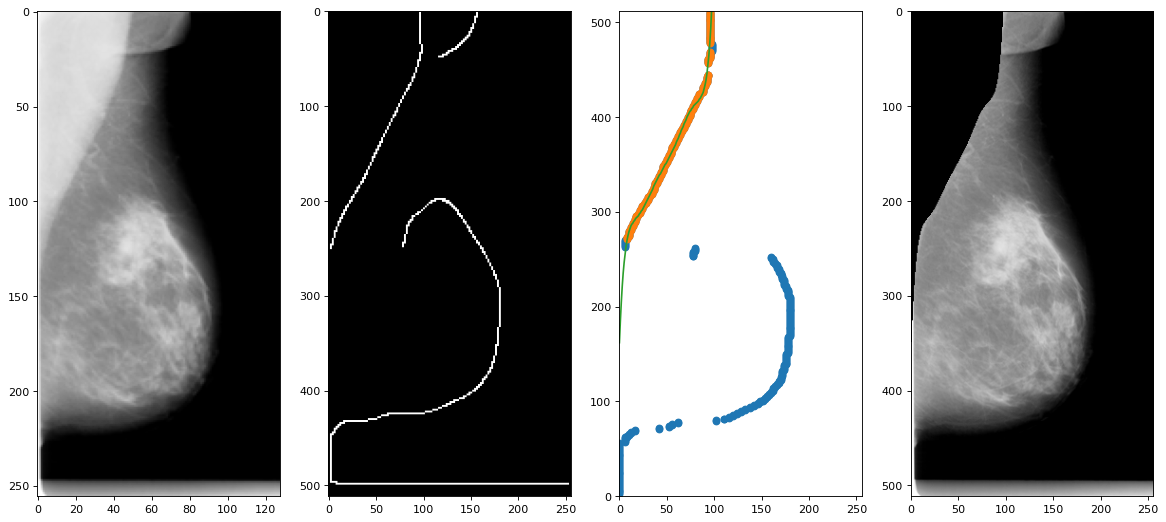

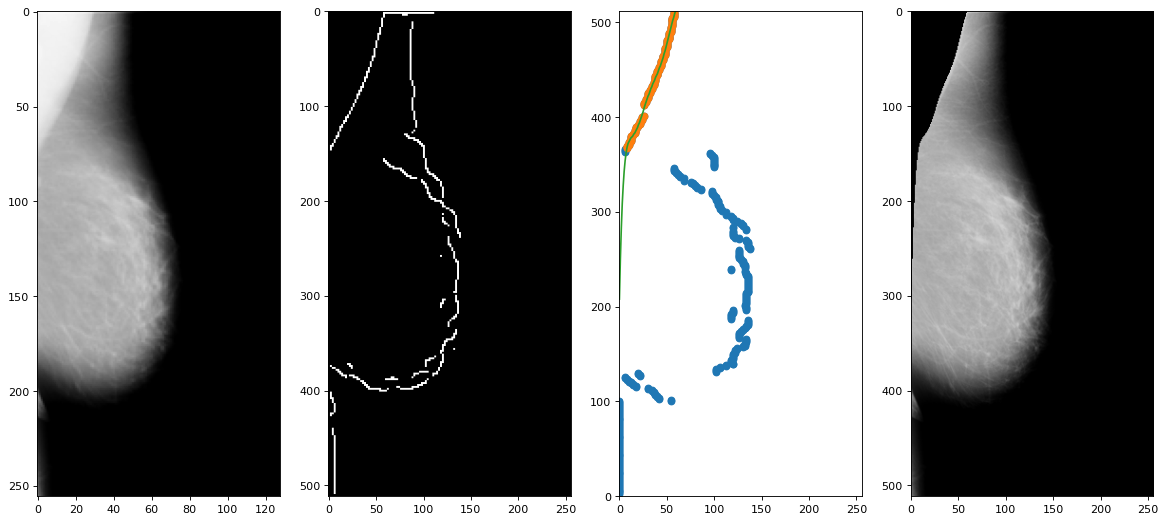

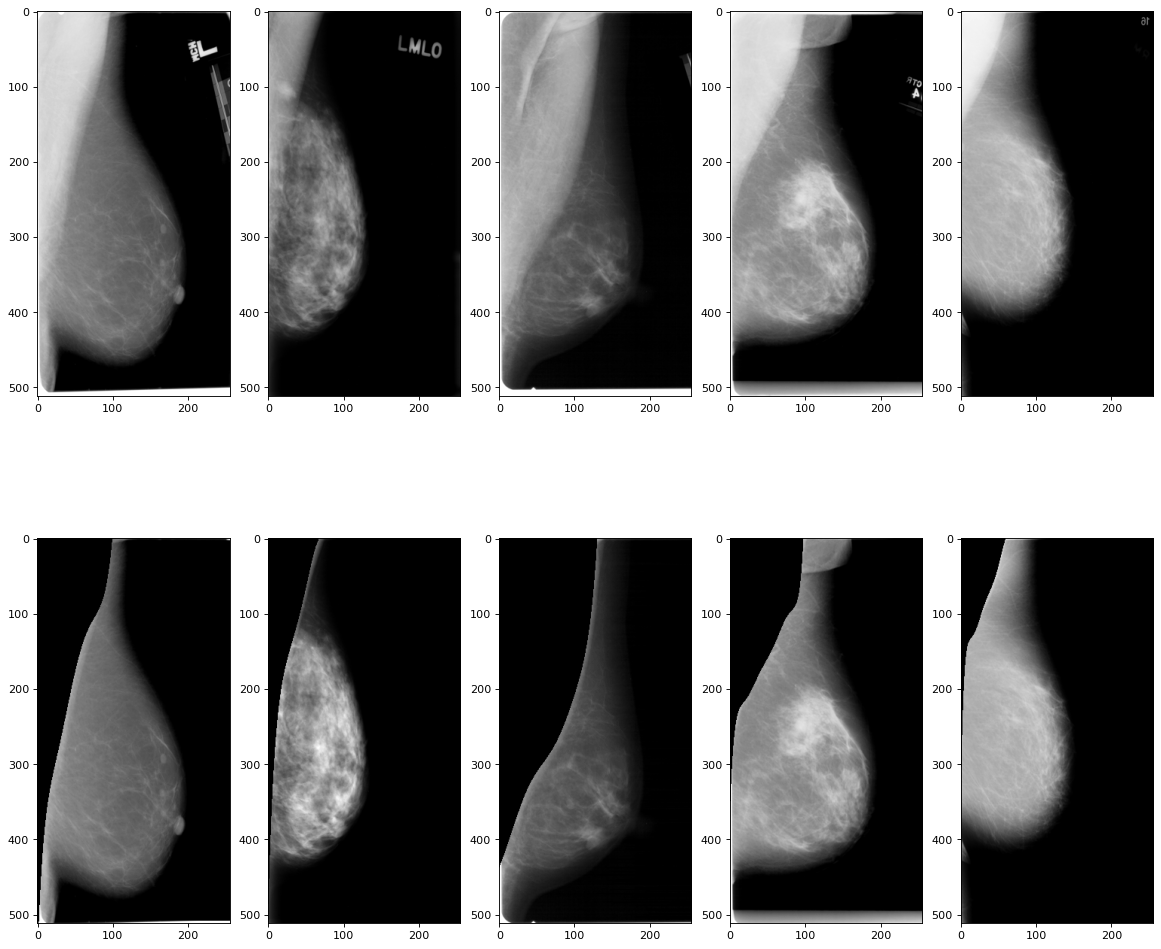

In [17]:
fname = ['Mass-Test_P_00099_LEFT_MLO', 'Mass-Test_P_00114_LEFT_MLO','Mass-Test_P_00126_RIGHT_MLO','Mass-Test_P_00203_LEFT_MLO', 'Mass-Test_P_01090_RIGHT_MLO']
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ogIm = []
img = []
for i in range(len(fname)):
    ogIm.append(flipImage(readResize("D:/DDSM_Data/DDSM_Mass/Train/Benign/" + fname[i] + ".jpg", (256,512))))
    img.append(preProcess("D:/DDSM_Data/DDSM_Mass/Train/Benign/" + fname[i] + ".jpg", (256,512)))

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(len(fname)):
    plt.subplot(2,len(fname),i+1)
    plt.imshow(ogIm[i],cmap='gray')
    plt.subplot(2,len(fname),i+len(fname)+1)
    plt.imshow(img[i], cmap='gray')


In [12]:
def cropPecCanny(img, degree=3, cannyNum=3):
    newIm = copy(img)
    finIm = copy(img)
    newIm = Image.fromarray(newIm)
    newIm = newIm.resize((128,256))
    newIm = np.array(newIm)
    
    cannyIm = canny(newIm, cannyNum)
    cannyIm = Image.fromarray(cannyIm)
    cannyIm = cannyIm.resize((img.shape[1],img.shape[0]))
    cannyIm = np.array(cannyIm)
        
    coords = []
    y = []
    checkCount = 0
    check = False
    for row in range(cannyIm.shape[0]):
        if check == True:
            checkCount += 1
        else:
            checkCount = 0
        if checkCount > 10:
            coords.append(0)
            y.append(row)
        else:
            for col in range(cannyIm.shape[1]):
                if cannyIm[row][col] == True and col > 5:
                    coords.append(col)
                    y.append(row)
                    check = False
                    break
                else:
                    check = True

    y.reverse()
    
    merge = []
    for i in range(len(y)):
        merge.append([y[i], coords[i]])
      
    i = 0
    
    while i < len(merge):
        cond1 = merge[i][1] <= cannyIm.shape[1]/40 # Pixel not in first 10 cols
        cond2 = merge[i][1] >= cannyIm.shape[1]*60/100 # Pixel not in last 60% cols
        cond3 = merge[i][0] < cannyIm.shape[0]/5 # Pixel not in last 1/3rd
        cond4 = i > 0 and merge[i][1] > merge[i-1][1]
        cond5 = i > 0 and merge[i][0] < (merge[i-1][0] - cannyIm.shape[0]/8)
        
        if cond1 or \
            cond2 or \
            cond3 or \
            cond4 or \
            cond5:
                merge.pop(i)
        else:
            i += 1
        
    x_n = []
    y_n = []

    for ind in range(len(merge)):
        x_n.append(merge[ind][1])
        y_n.append(merge[ind][0])
        
    coeffs = np.polyfit(x_n,y_n,degree)
    poly = np.poly1d(coeffs)
    
    new_x = np.linspace(0,cannyIm.shape[1],cannyIm.shape[1])
    new_y = poly(new_x).round(0)
    
    for col in range(img.shape[1]):
        for row in range(img.shape[0]):
            if row < img.shape[0] - new_y[col] and col <= max(x_n):
                finIm[row][col] = 0
                
    cutPoints = []
    bot = min(new_y, key=lambda x:abs(x-0))
    top = min(new_y, key=lambda x:abs(x-img.shape[0]))
    botNum = new_x[np.where(new_y==bot)][0]
    topNum = new_x[np.where(new_y==top)][0]
                                   
    if abs(botNum - topNum) < finIm.shape[1]/10:
        raise cutError        
        
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')    
    plt.subplot(1,4,4)
    plt.imshow(finIm, cmap='gray')
    plt.subplot(1,4,2)
    plt.imshow(cannyIm, cmap='gray')
    plt.subplot(1,4,3)
    plt.plot(coords, y, 'o')
    plt.axis('scaled')
    plt.ylim(0,cannyIm.shape[0])
    plt.xlim(0,cannyIm.shape[1])
    plt.plot(x_n, y_n, 'o', new_x, new_y)
    plt.axis('scaled')
    plt.ylim(0,cannyIm.shape[0])
    plt.xlim(0,cannyIm.shape[1])
    plt.subplot(1,4,1)
    plt.imshow(newIm, cmap='gray')
    plt.show(fig)
    
    return finIm

In [5]:
class cutError(Exception):
    pass

In [6]:
def readResize(img_path, shape):
    img = plt.imread(img_path)
    img = Image.fromarray(img)
    img = img.resize(shape)
    img = np.array(img)
    
    return img

In [7]:
def flipImage(img):
    leftCount = []
    rightCount = []
    for row in range(img.shape[0]):
        leftCount.append(img[row][0:int(img.shape[1]/2)])
        rightCount.append(img[row][int(img.shape[1]/2):img.shape[1]-1])
    left = np.mean(leftCount)
    right = np.mean(rightCount)
    if right > left:
        img = np.fliplr(img)
    
    return img

In [8]:
def backgroundRemoval(img):
    for row in range(img.shape[0]):
        black = False
        for col in range(img.shape[1]):
            if black == True:
                img[row][col] = 0
            elif img[row][col] == 0 and col > img.shape[1]/2:
                black = True
    
    return img

In [9]:
def barRemover(img, intensity):
    newIm = copy(img)
    row = 0
    while row < newIm.shape[0]:
        if np.mean(newIm[row]) >= intensity:
            newIm = np.delete(newIm, row, 0)
        else:
            row += 1
    
    
    reIm = Image.fromarray(newIm)
    reIm = reIm.resize((img.shape[1], img.shape[0]))
    newIm = np.array(reIm)
    
    return newIm